<a href="https://colab.research.google.com/github/moustafa-7/League-of-legends_Bigdata/blob/main/Bigdata_miniprojects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initial Setup

In [ ]:
!sudo apt install p7zip-full

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


In [ ]:
# !7z e drive/MyDrive/matches.jsonl.7z

In [ ]:
# !head -3000 matches.jsonl > drive/MyDrive/small_matches.jsonl

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

In [147]:
import findspark
findspark.init()
import pyspark
import random
import time
import matplotlib.pyplot as plt
import pandas as pd

In [70]:
def tags(champion_id):
  for c in champion_classes:
    if champion_id==c["championId"]:
      return c["tags"]

In [71]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("LOL").getOrCreate()
sc = spark.sparkContext

# either reading 1339 or 3000 matches
# d = spark.read.json("drive/MyDrive/small_matches.json", multiLine=True)
d = spark.read.json("drive/MyDrive/small_matches.jsonl", multiLine=False)

In [ ]:
no_matches = d.count()
print(no_matches)

3000


## 1. Champions win - pick - ban rates

In this requirement, we are asked to return the rates of each champion (normalized) 

In [163]:
def champions(row):
  """
  This function takes a match and output the following
  A list of all champions in this match either winnign champions or losing champions or banned. and then passed to a flat map
  """
  c = []
  bans = []
  for p in row["participants"]:
    # decide which team is this champion to know either this champion won or lost
    if(p["teamId"] == "Blue"): team_number = 0
    else: team_number = 1
    # append each champion and either won or lost
    c.append((p["championId"], row["teams"][team_number]["win"]))
  
  # loop over banned list and append it to the c (champions) list along with the banned list.
  for t in row["teams"]:
    for b in t["bans"]:
      if(b["championId"] != None):
        c.append((b["championId"],"ban"))

  return c

In [164]:
# get champions (and their tags) by passing the matches to champions functions
champions = d.rdd.flatMap(champions)

In [165]:
import time
def lookup(champions):
  for c in champions.collect():
    print(c)
    time.sleep(0.1)

In [166]:
# group all output values by championId and then convert all tags to a list so the final layout is:
#   championId: list[win, lost, banned, .......]
by_champion = champions.groupByKey().mapValues(list)

In [185]:
def compute_champion_rates(val):
  """
  This function takes a champion and counts how many times it was banned, won, and lost and normalize each rate.
  """
  ban_count = val.count("ban")
  win_count = val.count("Win")
  lose_count = val.count("Fail")
  total_played_games = win_count+lose_count
  
  # some times a champion maybe banned but was never chosen by a user so it just return "never played" instead of win and lose rates
  if(total_played_games):
    return [ban_count/no_matches, total_played_games/no_matches, win_count/total_played_games, lose_count/total_played_games]
  else:
    return [ban_count/no_matches, "never_played", "never_played"]

In [193]:
win_pick_ban_rates = by_champion.map(lambda x:(x[0], compute_champion_rates(x[1]))).filter(lambda x: x[1][2] is not 'never_played')
# ban, pick, win, lose rates in a python list type
champion_rates_list = win_pick_ban_rates.collect()

In [194]:
N = 10

In [ ]:
# sorted(champion_rates_list, key = lambda x : x[1][0])[:10]
champion_rates_list

In [196]:
# sort depending on each rate (top 10)

# top banned
top_banned_champions = sorted(champion_rates_list, key = lambda x: x[1][0], reverse = True)[:N] 

# top picked
top_picked_champions = sorted(champion_rates_list, key = lambda x: x[1][1], reverse = True)[:N] 

# top winning
top_winning_champions = sorted(champion_rates_list, key = lambda x: x[1][2], reverse = True)[:N] 

# top losing
top_losing_champions = sorted(champion_rates_list, key = lambda x: x[1][3], reverse = True)[:N] 

In [199]:
def show_rate(top_rate_champions,rate_category, bar_name):
  c_id, c_rates = zip(*top_rate_champions)
  ban = []
  pick = []
  win = []
  lose = []
  for r in c_rates:
    ban.append(r[0])
    pick.append(r[1])
    win.append(r[2])
    lose.append(r[3])

  c_table = {"id": c_id, "ban": ban, "pick": pick, "win":win, 'lose':lose}

  c_df = pd.DataFrame(c_table, columns = ['id', 'ban', 'pick', 'win', 'lose'])
  width = 0.25
  fig, ax = plt.subplots(figsize=(20,5))
  pos = list(range(len(c_df['id'])))
  plt.bar(c_df["id"], c_df[rate_category], width, alpha=0.5, color='#EE3224')
  ax.set_title(bar_name)
  ax.set_ylabel('rate')
  ax.set_xticklabels(c_df['id'])
  plt.show()


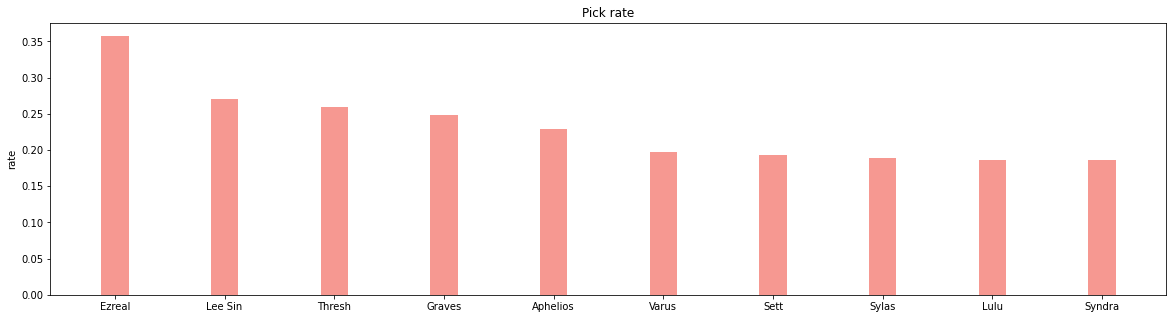

In [202]:
show_rate(top_picked_champions, "pick", "Pick rate")

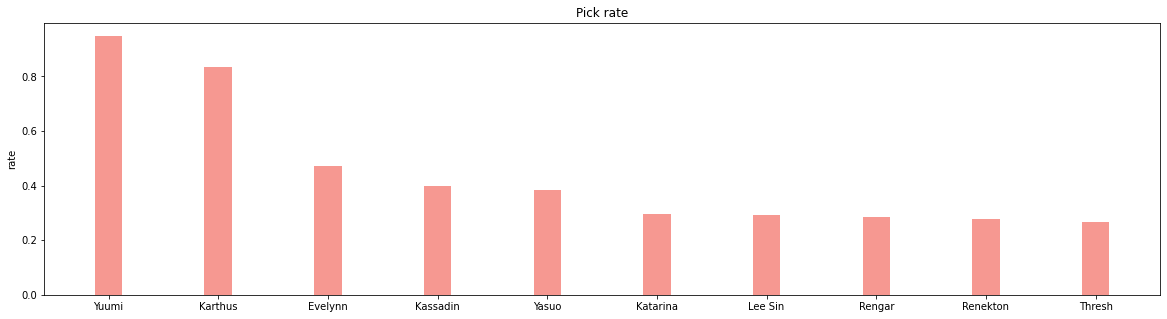

In [203]:
show_rate(top_banned_champions, "ban", "Ban rate")

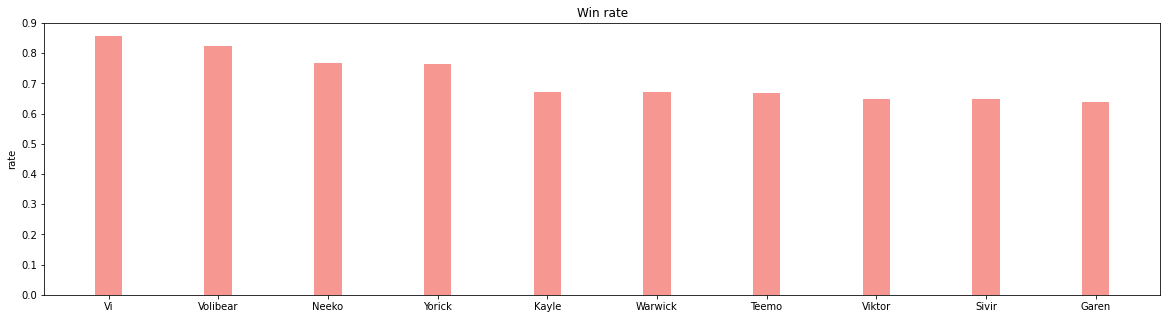

In [205]:
show_rate(top_winning_champions, "win", "Win rate")

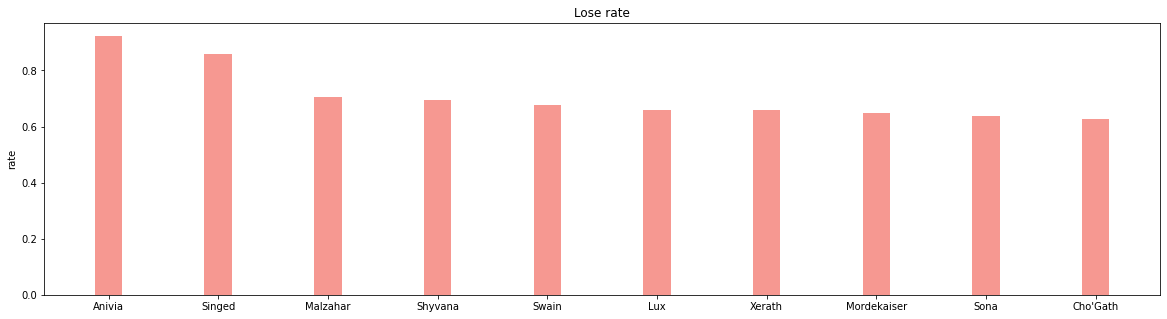

In [206]:
show_rate(top_losing_champions, "lose", "Lose rate")

## 2. Champion Synergies or Duos

In [ ]:
import itertools
def champion_duos(row):
  duos = []
  team1 = []
  team2 = []
  is_team1_win = False
  is_team2_win = False
  for p in row["participants"]:
    if(p["teamId"] == "Blue"): 
      team_number = 0
    else: 
      team_number = 1
    
    if(team_number == 0):
      team1.append(p["championId"])
      is_team1_win = p["stats"]["win"]
    else:
      team2.append(p["championId"])
      is_team2_win = p["stats"]["win"]
  
  team1 = sorted(team1)
  team2 = sorted(team2)
  for c in list(itertools.combinations(team1, 2)):
    if is_team1_win:
      duos.append((c, 1.5))
    else:
      duos.append((c, 1))

  for c in list(itertools.combinations(team2, 2)):
    if is_team2_win:
      duos.append((c, 1.5))
    else:
      duos.append((c, 1))

  
  return duos

In [ ]:
duos = d.rdd.flatMap(champion_duos)

In [ ]:
from operator import add
duos_count = duos.reduceByKey(add)

In [ ]:
# for c in duos_count.collect():
#     print(c)
#     time.sleep(0.01)

top_duos = duos_count.top(50, key=lambda x: x[1])
for c in top_duos[:10]:
    print(c)
    time.sleep(0.01)

(('Ezreal', 'Yuumi'), 99.0)
(('Aphelios', 'Thresh'), 87.5)
(('Ezreal', 'Sett'), 73.0)
(('Thresh', 'Varus'), 70.5)
(('Graves', 'Thresh'), 70.0)
(('Ezreal', 'Graves'), 67.0)
(('Ezreal', 'Lee Sin'), 65.5)
(('Lee Sin', 'Thresh'), 64.0)
(('Aphelios', 'Lulu'), 61.5)
(('Lee Sin', 'Syndra'), 60.0)


## 3. Item Win - pick rates

In [ ]:
def get_items(row):
  c = []
  bans = []
  for p in row["participants"]:
    for i in range(7):
      c.append((p["stats"]["item"+str(i)]["name"], p["stats"]["win"]))
  return c

In [ ]:
items = d.rdd.flatMap(get_items).groupByKey().mapValues(list)

In [ ]:

print(len(items.collect()))

190


In [ ]:
def compute_item_rates(val):
  win_count = val.count(True)
  lose_count = val.count(False)
  total_played_games = win_count+lose_count
  return [win_count/total_played_games, len(val)/no_matches]

In [ ]:
item_rates = items.map(lambda x:(x[0], compute_item_rates(x[1])))

In [ ]:
print("item       win_rate        pick_rate")
for item in item_rates.collect()[:10]:
    print(item)
    time.sleep(0.01)

item       win_rate        pick_rate
('Shard of True Ice', [0.5265423242467718, 0.520537714712472])
("Athene's Unholy Grail", [0.5107033639143731, 0.48842419716206126])
('Ardent Censer', [0.5220458553791887, 0.4234503360716953])
("Mercury's Treads", [0.53621103117506, 1.5571321882001494])
('Cloth Armor', [0.40292275574112735, 0.3577296489917849])
('Sapphire Crystal', [0.15384615384615385, 0.02912621359223301])
('Oracle Lens', [0.5067150635208711, 4.1150112023898435])
('Bilgewater Cutlass', [0.47368421052631576, 0.1135175504107543])
('Iceborn Gauntlet', [0.5581395348837209, 0.22479462285287527])
('Muramana', [0.5550314465408805, 0.4749813293502614])


## 4. Item synergies (with champion, with class)

In [ ]:
import json

classes = open("drive/MyDrive/champion_class.json")
champion_classes = json.load(classes)

In [ ]:
def tags(champion_id):
  for c in champion_classes:
    if champion_id==c["championId"]:
      return c["tags"]

In [ ]:
print(*tags("Ahri"))

Mage Assassin


In [ ]:
def get_items_champion(row):
  c = []
  for p in row["participants"]:
    for i in range(7):
      # c.append((p["stats"]["item"+str(i)]["name"], p["stats"]["win"], p["championId"], *tags(p["championId"])))
      if(tags(p["championId"])):
        c.append((p["stats"]["item"+str(i)]["name"], (p["stats"]["win"], p["championId"],*tags(p["championId"]))))
  return c

In [ ]:
items_champion = d.rdd.flatMap(get_items_champion).groupByKey().mapValues(list)

In [ ]:
for item in items_champion.collect()[:10]:
    print(item)
    time.sleep(0.1)

# print(len(items_champion.collect()))

('Shard of True Ice', [(False, 'Karma', 'Mage', 'Support'), (True, 'Karma', 'Mage', 'Support'), (False, 'Soraka', 'Support', 'Mage'), (True, 'Morgana', 'Mage', 'Support'), (True, 'Karma', 'Mage', 'Support'), (False, 'Zyra', 'Mage', 'Support'), (False, 'Karma', 'Mage', 'Support'), (True, 'Yuumi', 'Support', 'Mage'), (False, 'Gragas', 'Fighter', 'Mage'), (True, 'Janna', 'Support', 'Mage'), (True, 'Bard', 'Support', 'Mage'), (True, 'Swain', 'Mage', 'Fighter'), (True, 'Bard', 'Support', 'Mage'), (True, 'Rakan', 'Support'), (True, 'Bard', 'Support', 'Mage'), (False, 'Janna', 'Support', 'Mage'), (True, 'Soraka', 'Support', 'Mage'), (False, 'Lulu', 'Support', 'Mage'), (False, 'Yuumi', 'Support', 'Mage'), (False, 'Morgana', 'Mage', 'Support'), (False, 'Morgana', 'Mage', 'Support'), (False, 'Yuumi', 'Support', 'Mage'), (False, 'Yuumi', 'Support', 'Mage'), (False, 'Soraka', 'Support', 'Mage'), (False, 'Janna', 'Support', 'Mage'), (False, 'Yuumi', 'Support', 'Mage'), (True, 'Lulu', 'Support', 'Ma

In [ ]:
def champion_item_synergies(row):
  champion_dict= {}
  for val in row[1]:
    if(val[1] in champion_dict):
      champion_dict[val[1]] += 1
    else:
      champion_dict[val[1]] = 1
    
    if(val[0] == True):
            champion_dict [val[1]] += 0.5

  c = []
  for k, r in sorted(champion_dict.items(), key=lambda x:x[1], reverse=True):
    c.append((k, r))

  return  c[:10]

In [ ]:
champion_item_synergy = items_champion.flatMap(lambda x:(x[0] ,champion_item_synergies(x)))

In [ ]:
for item in champion_item_synergy.collect()[:10]:
    print(item)
    time.sleep(0.1)

Shard of True Ice
('Shard of True Ice', [('Yuumi', 149.0), ('Lulu', 127.0), ('Karma', 123.0), ('Bard', 104.0), ('Janna', 92.5), ('Morgana', 58.0), ('Soraka', 33.0), ('Nami', 27.5), ('Fiddlesticks', 26.5), ('Brand', 21.0)])
Athene's Unholy Grail
("Athene's Unholy Grail", [('Yuumi', 224.5), ('Karma', 173.5), ('Janna', 107.0), ('Lulu', 90.5), ('Soraka', 45.5), ('Bard', 39.5), ('Ivern', 28.0), ('Rakan', 27.0), ('Nami', 25.5), ('Nidalee', 19.5)])
Ardent Censer
('Ardent Censer', [('Lulu', 278.0), ('Yuumi', 110.5), ('Karma', 103.5), ('Janna', 68.0), ('Soraka', 27.0), ('Ivern', 26.5), ('Rakan', 26.5), ('Nami', 24.5), ('Morgana', 19.5), ('Sona', 9.5)])
Mercury's Treads
("Mercury's Treads", [('Graves', 122.5), ('Sylas', 106.0), ('Irelia', 87.0), ('Renekton', 82.5), ('Sett', 70.5), ('Riven', 69.5), ('Bard', 67.5), ('Jayce', 60.0), ('Ekko', 57.5), ('Jax', 52.5)])
Cloth Armor
('Cloth Armor', [('Thresh', 49.0), ('Lulu', 32.5), ('Blitzcrank', 24.0), ('Sett', 21.5), ('Malphite', 18.5), ('Trundle', 18.

In [ ]:
def class_item_synergies(row):
  class_dict= {}
  for val in row[1]:
    for cls in val[2:]:
      if(cls in class_dict):
        class_dict[cls] += 1
      else:
        class_dict[cls] = 1
    
      if(val[0] == True):
        class_dict[cls] += 0.5

  c = []
  for k, r in sorted(class_dict.items(), key=lambda x:x[1], reverse=True):
    c.append((k, r))

  return (row[0], c[:3])

In [ ]:
class_item_synergy = items_champion.flatMap(lambda x: class_item_synergies(x))

In [ ]:
for item in class_item_synergy.collect()[:10]:
    print(item)
    time.sleep(0.1)

Shard of True Ice
[('Mage', 837.5), ('Support', 818.0), ('Fighter', 10.0)]
Athene's Unholy Grail
[('Support', 801.5), ('Mage', 785.5), ('Assassin', 19.5)]
Ardent Censer
[('Support', 715.0), ('Mage', 682.0), ('Fighter', 6.5)]
Mercury's Treads
[('Fighter', 1271.5), ('Tank', 760.5), ('Assassin', 710.0)]
Cloth Armor
[('Fighter', 320.0), ('Tank', 265.5), ('Support', 169.5)]


## 5. Item suggestion

In [ ]:
def champion_item(row):
  c = []
  for p in row["participants"]:
    # c.append(p["championId"])
    for i in range(7):
      if(p["stats"]["item"+str(i)]["gold"]):
        if (not p["stats"]["item"+str(i)]["into"]) and tags(p["championId"]) and (p["stats"]["item"+str(i)]["gold"]["total"] >= 1000):
          c.append((p["championId"], ( p["stats"]["item"+str(i)]["name"], p["stats"]["win"], *tags(p["championId"]) )))
  return  c

In [ ]:
c_item_class = d.rdd.flatMap(champion_item).groupByKey().mapValues(list)

In [ ]:
for item in c_item_class.collect():
    print(item)
    time.sleep(0.1)

('Karma', [("Athene's Unholy Grail", False, 'Mage', 'Support'), ('Ardent Censer', False, 'Mage', 'Support'), ("Mercury's Treads", False, 'Mage', 'Support'), ("Sorcerer's Shoes", True, 'Mage', 'Support'), ("Athene's Unholy Grail", True, 'Mage', 'Support'), ('Ardent Censer', True, 'Mage', 'Support'), ('Ardent Censer', True, 'Mage', 'Support'), ('Boots of Mobility', True, 'Mage', 'Support'), ("Athene's Unholy Grail", True, 'Mage', 'Support'), ('Boots of Mobility', False, 'Mage', 'Support'), ("Athene's Unholy Grail", False, 'Mage', 'Support'), ('Ardent Censer', False, 'Mage', 'Support'), ('Boots of Mobility', False, 'Mage', 'Support'), ('Ardent Censer', True, 'Mage', 'Support'), ("Athene's Unholy Grail", True, 'Mage', 'Support'), ("Sorcerer's Shoes", True, 'Mage', 'Support'), ("Athene's Unholy Grail", True, 'Mage', 'Support'), ('Ardent Censer', False, 'Mage', 'Support'), ("Athene's Unholy Grail", False, 'Mage', 'Support'), ("Liandry's Torment", True, 'Mage', 'Support'), ("Sorcerer's Shoes"

In [62]:
def champion_item_suggest(row):
  item_dict= {}
  for val in row[1]:
    if(val[0] in item_dict):
      item_dict[val[0]] += 1
    else:
      item_dict[val[0]] = 1
    
    if(val[0] == True):
            item_dict [val[0]] += 1

  c = []
  for k, r in sorted(item_dict.items(), key=lambda x:x[1], reverse=True):
    c.append((k, r))

  
  return (row[0], (c[:10]))

In [67]:
champion_item_suggestion = c_item_class.map(lambda x: champion_item_suggest(x))

In [68]:
for item in champion_item_suggestion.collect():
    print(item)
    time.sleep(0.01)

('Karma', [("Athene's Unholy Grail", 310), ('Ardent Censer', 170), ('Boots of Mobility', 54), ("Sorcerer's Shoes", 49), ("Shurelya's Reverie", 27), ('Ninja Tabi', 25), ("Mercury's Treads", 21), ("Mikael's Crucible", 15), ('Morellonomicon', 10), ('Twin Shadows', 9)])
('Ezreal', [('Muramana', 897), ('Manamune', 128), ('Ninja Tabi', 90), ('Mortal Reminder', 65), ('Maw of Malmortius', 45), ("Mercury's Treads", 42), ('Duskblade of Draktharr', 35), ('Guardian Angel', 33), ('Mercurial Scimitar', 27), ('Bloodthirster', 26)])
('Mordekaiser', [("Liandry's Torment", 81), ('Ninja Tabi', 63), ('Hextech Protobelt-01', 51), ("Nashor's Tooth", 40), ("Mercury's Treads", 39), ("Rylai's Crystal Scepter", 28), ("Sorcerer's Shoes", 8), ('Morellonomicon', 6), ('Thornmail', 3), ('Spirit Visage', 2)])
('Heimerdinger', [("Sorcerer's Shoes", 176), ('Morellonomicon', 54), ("Liandry's Torment", 27), ('Void Staff', 16), ("Banshee's Veil", 10), ('Hextech GLP-800', 6), ("Rylai's Crystal Scepter", 4), ("Zhonya's Para